# Homework 7

1. Following our discussion/confusion on the `r2_score`: think about the shortcomings of using the squared correlation coefficient as a quality of fit measure. Construct a few simple examples, that highlight, why `np.corrcoef(y_test,yHat)**2` would be a very poor choice.

2. Look up the sklearn help file for [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) and translate the statsmodel from below into the corresponding sklearn version, using `LinearRegression()` only.
3. Look up the `patsy` help file for [dmatrix](https://patsy.readthedocs.io/en/latest/formulas.html#redundancy-and-categorical-factors) and translate the statsmodel from below into the corresponding sklearn version, using `LinearRegression()` only.

4. Estimate the *10-fold* CV error on this model.



**Importing libraries**

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#import statsmodels.api as sm
import statsmodels.formula.api as smf
#import patsy
from patsy import dmatrices
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

**Loading the dataframe**

In [2]:
boston = pd.read_csv('../data/boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv'].values
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
model = smf.ols('medv ~ lstat*rm + C(chas) + crim ', boston).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-29.8113,3.268,-9.121,0.000,-36.233,-23.390
C(chas)[T.1],3.2168,0.803,4.006,0.000,1.639,4.795
lstat,2.2458,0.201,11.170,0.000,1.851,2.641
rm,9.6980,0.489,19.843,0.000,8.738,10.658
lstat:rm,-0.4818,0.034,-14.346,0.000,-0.548,-0.416
crim,-0.1138,0.027,-4.278,0.000,-0.166,-0.062


## Shortcomings of r2_score

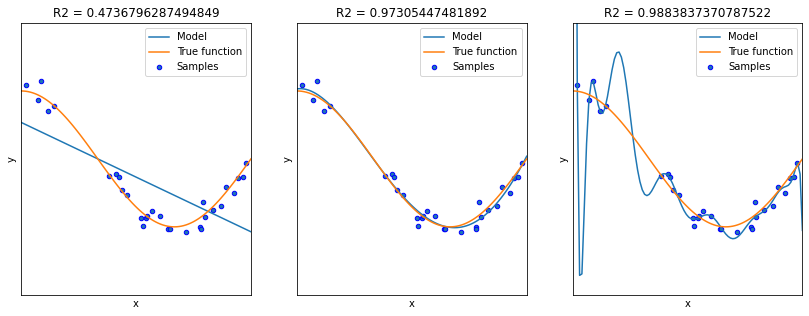

In [4]:
# I did not create these charts. Please see https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the model
    scores = r2_score(y,pipeline.predict(X[:, np.newaxis])) 

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "R2 = {}".format(scores)
    )
plt.show()

## Polynomial Features

In [6]:
X = boston.drop('medv', axis=1)
y = boston['medv'].values

X_trans = X[["chas", "crim"]].copy()

#change chas to categorical
X_trans["chas"] = X_trans["chas"].astype("category")

#Create polynomial feature for lstat*rm
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

#Create df of polynomial features
X_poly = pd.DataFrame(poly.fit_transform(X[["lstat","rm"]]), columns=["lstat","rm","lstat*rm"])

#Create X df for Linear Regression model
X_trans = pd.concat([X_poly, X_trans], axis=1)
X_trans.head()

,lstat,rm,lstat*rm,chas,crim
0,4.98,6.575,32.74350,0,0.00632
1,9.14,6.421,58.68794,0,0.02731
2,4.03,7.185,28.95555,0,0.02729
3,2.94,6.998,20.57412,0,0.03237
4,5.33,7.147,38.09351,0,0.06905


In [7]:
lin_model1 = LinearRegression().fit(X_trans, y)

In [8]:
lin_model1.coef_

array([ 2.24584117,  9.69798331, -0.48180729,  3.21678536, -0.11376058])

In [9]:
lin_model1.intercept_

-29.811325182078814

## Patsy

In [10]:
formula = 'medv ~ lstat*rm + C(chas) + crim'
y_t, X_t = dmatrices(formula, boston, return_type='dataframe')

In [12]:
X_t.head()

,Intercept,C(chas)[T.1],lstat,rm,lstat:rm,crim
0,1.0,0.0,4.98,6.575,32.74350,0.00632
1,1.0,0.0,9.14,6.421,58.68794,0.02731
2,1.0,0.0,4.03,7.185,28.95555,0.02729
3,1.0,0.0,2.94,6.998,20.57412,0.03237
4,1.0,0.0,5.33,7.147,38.09351,0.06905


In [13]:
lin_model2 = LinearRegression().fit(X_t, y_t)

In [14]:
lin_model2.coef_

array([[ 0.        ,  3.21678536,  2.24584117,  9.69798331, -0.48180729,
        -0.11376058]])

In [15]:
lin_model2.intercept_

array([-29.81132518])

### Estimate the 10-fold CV error on this model

In [16]:
#Shuffle dataset
from sklearn.utils import shuffle
X_t_s, y_t_s = shuffle(X_t, y_t)

In [17]:
# 10 fold cross validation scoring for R2 and MSE
cv_scores = cross_validate(LinearRegression(), X_t_s, y_t_s, cv=10, scoring=["neg_mean_squared_error","r2"])
mse_cv = cv_scores["test_neg_mean_squared_error"]
r2_cv = cv_scores["test_r2"]

In [18]:
#10-fold cv R2
r2_cv

array([0.78870046, 0.72401524, 0.82209935, 0.81921883, 0.79529233,
       0.79587371, 0.44150591, 0.81696138, 0.66487041, 0.68345067])

In [19]:
#Mean of 10-fold cv R2
r2_cv.mean()

0.7351988295193845

In [20]:
#10-fold cv MSE
mse_cv

array([-13.57810987, -27.74894842, -12.49631243, -14.25004771,
       -12.44115629, -15.24469936, -35.61222147, -20.8673694 ,
       -26.85203146, -39.44233138])

In [21]:
#mean of 10-fold cv MSE
mse_cv.mean()

-21.85332278058473